In [0]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
#%matplotlib inline
#%load_ext watermark
#%load_ext autoreload
#%autoreload 2
#%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

#%watermark -a 'Ethen' -d -t -v -p numpy,scipy,pandas,sklearn,matplotlib,seaborn

In [3]:
from google.colab import files
uploaded = files.upload()

Saving rhc.csv to rhc.csv


In [5]:
# we'll only be working with a subset of the variables in the raw dataset,
# feel free to experiment with more
AGE = 'age'
MEANBP1 = 'meanbp1'
CAT1 = 'cat1'
SEX = 'sex'
DEATH = 'death' # outcome variable in the our raw data
SWANG1 = 'swang1' # treatment variable in our raw data
TREATMENT = 'treatment'

num_cols = [AGE, MEANBP1]
cat_cols = [CAT1, SEX, DEATH, SWANG1]

input_path = 'rhc.csv'
dtype = {col: 'category' for col in cat_cols}
df = pd.read_csv(input_path, usecols=num_cols + cat_cols, dtype=dtype)
print(df.shape)
df.head()

(5735, 6)


,cat1,death,age,sex,meanbp1,swang1
0,COPD,No,70.25098,Male,41.0,No RHC
1,MOSF w/Sepsis,Yes,78.17896,Female,63.0,RHC
2,MOSF w/Malignancy,No,46.09198,Female,57.0,RHC
3,ARF,Yes,75.33197,Female,55.0,No RHC
4,MOSF w/Sepsis,Yes,67.90997,Male,65.0,RHC


In [6]:
# replace this column with treatment yes or no
df[SWANG1].value_counts()


No RHC    3551
RHC       2184
Name: swang1, dtype: int64

In [7]:
# replace these values with shorter names
df[CAT1].value_counts()

ARF                  2490
MOSF w/Sepsis        1227
COPD                  457
CHF                   456
Coma                  436
MOSF w/Malignancy     399
Cirrhosis             224
Lung Cancer            39
Colon Cancer            7
Name: cat1, dtype: int64

In [8]:
cat1_col_mapping = {
    'ARF': 'arf',
    'MOSF w/Sepsis': 'mosf_sepsis',
    'COPD': 'copd',
    'CHF': 'chf',
    'Coma': 'coma',
    'MOSF w/Malignancy': 'mosf',
    'Cirrhosis': 'cirrhosis',
    'Lung Cancer': 'lung_cancer',
    'Colon Cancer': 'colon_cancer'
}
df[CAT1] = df[CAT1].replace(cat1_col_mapping)

# convert features' value to numerical value, and store the
# numerical value to the original value mapping
col_mappings = {}
for col in (DEATH, SWANG1, SEX):
    col_mapping = dict(enumerate(df[col].cat.categories))
    col_mappings[col] = col_mapping
print(col_mappings)

for col in (DEATH, SWANG1, SEX):
    df[col] = df[col].cat.codes

df = df.rename({SWANG1: TREATMENT}, axis=1)
df.head()

{'death': {0: 'No', 1: 'Yes'}, 'swang1': {0: 'No RHC', 1: 'RHC'}, 'sex': {0: 'Female', 1: 'Male'}}


,cat1,death,age,sex,meanbp1,treatment
0,copd,0,70.25098,1,41.0,0
1,mosf_sepsis,1,78.17896,0,63.0,1
2,mosf,0,46.09198,0,57.0,1
3,arf,1,75.33197,0,55.0,0
4,mosf_sepsis,1,67.90997,1,65.0,1


In [9]:
cat_cols = [CAT1]
df_one_hot = pd.get_dummies(df[cat_cols], drop_first=True)
df_cleaned = pd.concat([df[num_cols], df_one_hot, df[[SEX, TREATMENT, DEATH]]], axis=1)
df_cleaned.head()

,age,meanbp1,cat1_chf,cat1_cirrhosis,cat1_colon_cancer,cat1_coma,cat1_copd,cat1_lung_cancer,cat1_mosf,cat1_mosf_sepsis,sex,treatment,death
0,70.25098,41.0,0,0,0,0,1,0,0,0,1,0,0
1,78.17896,63.0,0,0,0,0,0,0,0,1,0,1,1
2,46.09198,57.0,0,0,0,0,0,0,1,0,0,1,0
3,75.33197,55.0,0,0,0,0,0,0,0,0,0,0,1
4,67.90997,65.0,0,0,0,0,0,0,0,1,1,1,1


In [10]:
features = df_cleaned.columns.tolist()
features.remove(TREATMENT)
features.remove(DEATH)
agg_operations = {TREATMENT: 'count'}
agg_operations.update({
    feature: ['mean', 'std'] for feature in features
})

table_one = df_cleaned.groupby(TREATMENT).agg(agg_operations)
# merge MultiIndex columns together into 1 level
# table_one.columns = ['_'.join(col) for col in table_one.columns.values]
table_one.head()

treatment        age             ... cat1_mosf_sepsis       sex          
              count       mean        std  ...              std      mean       std
treatment                                  ...                                     
0              3551  61.760926  17.287674  ...         0.355555  0.539003  0.498547
1              2184  60.749836  15.630698  ...         0.466781  0.585165  0.492806

[2 rows x 23 columns]

In [11]:
def compute_table_one_smd(table_one: pd.DataFrame, round_digits: int=4) -> pd.DataFrame:
    feature_smds = []
    for feature in features:
        feature_table_one = table_one[feature].values
        neg_mean = feature_table_one[0, 0]
        neg_std = feature_table_one[0, 1]
        pos_mean = feature_table_one[1, 0]
        pos_std = feature_table_one[1, 1]

        smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
        smd = round(abs(smd), round_digits)
        feature_smds.append(smd)

    return pd.DataFrame({'features': features, 'smd': feature_smds})


table_one_smd = compute_table_one_smd(table_one)
table_one_smd

,features,smd
0,age,0.0614
1,meanbp1,0.4551
2,cat1_chf,0.0950
3,cat1_cirrhosis,0.1447
4,cat1_colon_cancer,0.0376
5,cat1_coma,0.2073
6,cat1_copd,0.3424
7,cat1_lung_cancer,0.0950
8,cat1_mosf,0.0175
9,cat1_mosf_sepsis,0.4148


In [12]:
# treatment will be our label for estimating the propensity score,
# and death is the outcome that we care about, thus is also removed
# from the step that is estimating the propensity score
death = df_cleaned[DEATH]
treatment = df_cleaned[TREATMENT]
df_cleaned = df_cleaned.drop([DEATH, TREATMENT], axis=1)

column_transformer = ColumnTransformer(
    [('numerical', StandardScaler(), num_cols)],
    sparse_threshold=0,
    remainder='passthrough'
)
data = column_transformer.fit_transform(df_cleaned)
data.shape


(5735, 11)

In [13]:
logistic = LogisticRegression(solver='liblinear')
logistic.fit(data, treatment)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
pscore = logistic.predict_proba(data)[:, 1]
pscore

array([0.20154118, 0.550909  , 0.40984625, ..., 0.17665094, 0.18749943,
       0.22041186])

In [15]:
roc_auc_score(treatment, pscore)

0.6903390599356525

In [16]:
mask = treatment == 1
pos_pscore = pscore[mask]
neg_pscore = pscore[~mask]
print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

treatment count: (2184,)
control count: (3551,)


[0.550909   0.40984625 0.59452473 ... 0.5842305  0.59305161 0.57193994]


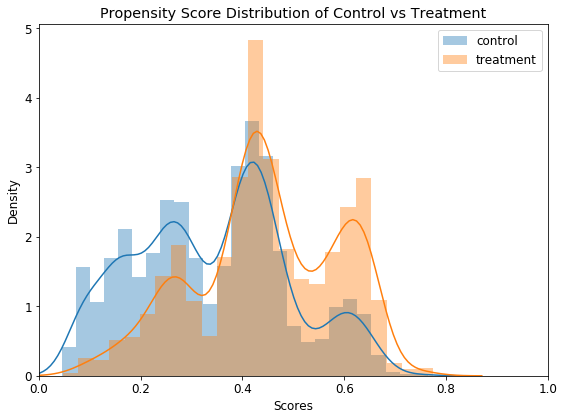

In [17]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

print(pos_pscore)
sns.distplot(neg_pscore, label='control')
sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [0]:
def get_similar(pos_pscore: np.ndarray, neg_pscore: np.ndarray, topn: int=5, n_jobs: int=1):
    from sklearn.neighbors import NearestNeighbors

    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_pscore.reshape(-1, 1))
    distances, indices = knn.kneighbors(pos_pscore.reshape(-1, 1))
    sim_distances = distances[:, 1:]
    sim_indices = indices[:, 1:]
    return sim_distances, sim_indices


sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)


In [19]:
_, counts = np.unique(sim_indices[:, 0], return_counts=True)
np.bincount(counts)

array([  0, 810, 309, 121,  47,  12,   6,   7,   3,   4])

In [20]:
df_cleaned[TREATMENT] = treatment
df_cleaned[DEATH] = death
df_pos = df_cleaned[mask]
df_neg = df_cleaned[~mask].iloc[sim_indices[:, 0]]
print(df_neg)
df_matched = pd.concat([df_pos, df_neg], axis=0)
df_matched.head()

           age  meanbp1  cat1_chf  ...  sex  treatment  death
2702  59.01199     51.0         1  ...    1          0      1
2127  42.56799     58.0         0  ...    0          0      1
4460  77.86694     62.0         0  ...    1          0      0
1355  82.60394     63.0         0  ...    0          0      1
4017  69.77399     51.0         0  ...    1          0      1
...        ...      ...       ...  ...  ...        ...    ...
2118  53.65598     41.0         0  ...    1          0      0
4636  47.51797    102.0         0  ...    1          0      0
2746  91.08795     47.0         0  ...    0          0      1
3042  45.02698     57.0         0  ...    0          0      0
4066  54.88300     44.0         1  ...    1          0      1

[2184 rows x 13 columns]


,age,meanbp1,cat1_chf,cat1_cirrhosis,cat1_colon_cancer,cat1_coma,cat1_copd,cat1_lung_cancer,cat1_mosf,cat1_mosf_sepsis,sex,treatment,death
1,78.17896,63.0,0,0,0,0,0,0,0,1,0,1,1
2,46.09198,57.0,0,0,0,0,0,0,1,0,0,1,0
4,67.90997,65.0,0,0,0,0,0,0,0,1,1,1,1
9,48.42398,73.0,0,0,0,0,0,0,0,0,0,1,0
11,68.34796,50.0,0,0,0,0,0,0,0,0,1,1,0


In [21]:
table_one_matched = df_matched.groupby(TREATMENT).agg(agg_operations)
table_one_smd_matched = compute_table_one_smd(table_one_matched)
table_one_smd_matched

,features,smd
0,age,0.0160
1,meanbp1,0.0072
2,cat1_chf,0.0184
3,cat1_cirrhosis,0.0091
4,cat1_colon_cancer,0.0707
5,cat1_coma,0.0091
6,cat1_copd,0.0557
7,cat1_lung_cancer,0.0626
8,cat1_mosf,0.0035
9,cat1_mosf_sepsis,0.0039


In [22]:
num_matched_pairs = df_neg.shape[0]
print('number of matched pairs: ', num_matched_pairs)

# pair t-test
stats.ttest_rel(df_pos[DEATH].values, df_neg[DEATH].values)

number of matched pairs:  2184


Ttest_relResult(statistic=2.98993204105555, pvalue=0.0028215776367738962)